# 蒙特卡洛积分工具及原理

庞龙刚@华中师范大学

## 学习目标

- 掌握高维蒙特卡洛积分工具 vegas
- 理解蒙特卡洛积分原理

## 学习内容

- vegas 库的安装、调用、输出结果分析
- 蒙特卡洛积分的原理
- vegas 蒙卡积分的缺陷及替代方案

In [2]:
## vegas 库用作高维蒙特卡洛积分
import vegas

import math
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.integrate import quad
from IPython.display import Image

plt.style.use(['science', 'notebook', 'no-latex'])

### 为何需要蒙特卡洛积分

高能物理研究经常要用到高维函数的数值积分。

传统的数值积分方法，比如梯形公式，辛普森积分，Gauss Quadrature 已经统统失效。

原因很简单，那些算法每个维度需要至少 M 个离散的数据点，对于 N 维积分，需要在 $M^{N}$ 个点上计算函数取值。
比如 10 维积分，每个维度用最节省的 15 个点的 Gauss Quadrature，需要计算的函数值的次数也达到了  $M^N = 15^{10} = 576650390625$   约 5766 亿次。

出现这种情况一般称作维数灾难。此时需要借助蒙特卡洛积分工具, 比如 vegas

### vegas 库的安装

```pip install --user vegas```

举例：计算如下 4 维高斯函数
\begin{align}
f(x_0, x_1, x_2, x_3) = N \exp(-\sum_{i=0}^{3} (x_i - \frac{1}{2})^2/0.01)
\end{align}
在闭区间 $x_0 \in [-1, 1], x_1 \in [0, 1],  x_2 \in [0, 1],  x_3 \in [0, 1]$ 上的数值积分结果。

其中 N = 1013.211 是归一化因子，对 f 的积分解析解为 1。

In [4]:
def f(x):
    ''':return: 4 维高斯分布函数'''
    dx2 = 0
    for d in range(4):
        dx2 += (x[d] - 0.5) ** 2
    return math.exp(-dx2 * 100.) * 1013.2118364296088


integ = vegas.Integrator([[-1, 1], [0, 1], [0, 1], [0, 1]])
result = integ(f, nitn=10, neval=1000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.51(21)        0.51(21)            0.00     1.00
  2   0.92(21)        0.72(15)            1.79     0.18
  3   0.910(77)       0.871(68)           1.53     0.22
  4   1.083(92)       0.946(55)           2.16     0.09
  5   1.038(51)       0.995(37)           2.00     0.09
  6   1.009(34)       1.002(25)           1.61     0.15
  7   1.032(27)       1.016(19)           1.45     0.19
  8   1.000(22)       1.009(14)           1.28     0.25
  9   1.014(19)       1.011(11)           1.13     0.34
 10   1.009(16)       1.0103(93)          1.00     0.43

result = 1.0103(93)    Q = 0.43


#### vegas 积分返回结果：

可以看到 result.summary() 返回了 10 次迭代的结果。

如果只想返回最终结果，去掉 summary(), 

result = 1.0101(93)

result 是一个 gvar 类型的数，括号里的数表示误差

使用 result.mean 返回均值 1.0101

使用 result.sdev 返回不确定部分  0.0093

#### 小技巧：如果积分变量 x[1] 的积分上限依赖积分变量 x[0], 如

\begin{align}
\int_0^1 dx_0 \int_0^{x_0} dx_1 \sin(x_0  x_1)
\end{align}

被积函数可以这样写：

```python
def f(x):
    if x[1] > x[0]: return 0
    return sin(x[0]*x[1])  
```

## 从黎曼积分到蒙特卡洛积分


黎曼积分 原理指导我们，为了求一维函数 f(x) 在闭区间 [a, b] 上的定积分，可以先把区间分成 n 份， $a < x_1 < x_2 < \cdots < x_{n-1} < b $, 其中每份格子大小为 $\Delta x_i = x_{i+1} - x_i$。

函数的积分近似等于小格子中**任一处的函数值** $f(x_i^*)$ 乘以 $\Delta x_i$ ，并对所有格子求和。

$F \approx \sum_i f(x_i^*) \Delta x_i $

因此可以使用均匀分布(uniform distribution) 的 $x_i$ 点上函数值 $f(x_i)$ 乘以平均间距 $\frac{b - a}{N}$ , 再求和来近似黎曼积分。

\begin{align}
F = \int_a^b f(x) dx \approx \frac{b - a}{N}\sum_{i=1}^N f(x_i)
\end{align}
其中 
- $\Delta x_i = {b - a \over N}$ 为相邻两个点的平均宽度
- $f(x_i)$ 是第 i 个 bin 中任一点处的函数值，可认为是 bin 的高度。

In [128]:
def plot_intg(n=500):
    # 可视化黎曼积分，积分区间 [-1, 2]
    x = -1 + 3 * np.random.rand(n)
    x = np.sort(x)
    y = lambda x: x**4 - 3*x**2 + 1
    plt.plot(x, y(x))
    plt.xlim(-1, 2)
    plt.ylim(-1.5, 3)
    
    anchors = [(xa, 0) for xa in x[:-1]]
    width = x[1:] - x[:-1] 
    r = np.random.rand(n-1)
    xi = x[:-1] + width * r
    yi = y(xi)
    intg_sum = (yi * width).sum()
    
    intg = quad(y, -1, 2)[0]
    plt.text(-0.5, 2.5, r"$\int_{-1}^{2} x^4 - 3 x^2 + 1 dx = %.6f$"%intg, size=15)
    plt.text(-0.5, 1.8, 
             r"$\sum_{i=0}^{%s} \Delta x_i\ f(x_i) =%.6f$"%(n-1, intg_sum),
             size=15)
    for i in range(len(x) - 1):
        r = Rectangle(anchors[i], width[i], yi[i], 
                      alpha=0.2,
                      edgecolor='k')
        plt.gca().add_patch(r)

Text(0, 0.5, 'f(x)')

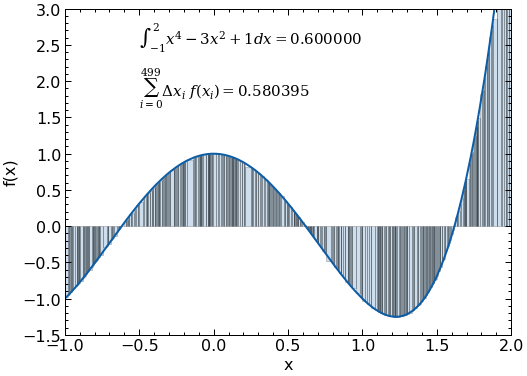

In [129]:
plot_intg(n=500)
plt.xlabel("x")
plt.ylabel("f(x)")

## 高维蒙卡积分原理

一维蒙卡积分可以写为积分区间的长度 b-a 乘以区间内函数的均值，

\begin{align}
\int_a^b f(x) dx \approx \frac{b - a}{N}\sum_{i=1}^N f(x_i) 
\end{align}

当 N 有限时，每次使用不同的随机数序列 $\{ x_i \}$ 计算得到的积分值有涨落，

这是因为均值 $\frac{1}{N}\sum_{i=1}^N f(x_i)$ 有涨落。

根据**大数定理(Law of large number)**，当 $N\rightarrow \infty$ 时，函数的均值收敛到其期望值（expectation value, 即期望中存在的理想的均值结果），

\begin{align}
E[f(x)] &= \lim_{N \rightarrow \infty} {1 \over N} \sum_{i=1}^N f(x_i)
\end{align}

函数的积分收敛到，

\begin{align}
\int_a^b f(x) dx & = \lim_{N \rightarrow \infty} {b - a \over N} \sum_{i=1}^N f(x_i) = (b - a) E[f(x)] 
\end{align}

蒙卡积分很容易推广到高维，只需要把一维积分中的积分区间 b-a 换成体积 $\mathcal{V}$, 然后在积分区间撒点得到 $f(x)$ 的平均值，

\begin{align}
F = \int_V f({\bf x}) dV  = \mathcal{V} \ \mathrm{E}\left[ f(x)\right] \approx  \frac{\mathcal{V}}{N}\sum_i^N f({\bf x_i})
\end{align}

只要积分区域能够给出，可以使用这种方法对任意不规则的高维区间积分。

蒙特卡洛方法非常依赖统计学的两个定理：
1. **大数定理 (Law of Large Numbers)**：当撒点足够多时，右边的求和收敛到左边期望值，
\begin{align}
E[f(x)] = \lim_{N\rightarrow \infty}{1 \over N} \sum_{i=1}^N f(x_i)
\end{align}
2. **中心极限定理 (Central Limit Theorem)**：多个独立同分布的随机数，如果均值和方差有限，则它们的和满足正态分布。


- 大数定理保证 $N\rightarrow \infty$ 时蒙特卡洛积分收敛
- 中心极限定理在撒点数目有限的情况下，可以估算蒙特卡洛积分的误差（正态分布的标准差）

In [134]:
# 数值验证大数定理: n 很大时， f(x_i) 的均值逐渐收敛到其期望值
def Law_Of_Large_Number(n):
    f = np.sin
    # mu = int_0^1 f(x) dx 为 np.sin 函数在 [0, 1] 区间的期望值
    mu = 1 - np.cos(1)
    x = np.random.rand(n)
    epsilon = np.mean(f(x)) - mu  
    return epsilon

# n 较小时，多次计算求和结果不一致，有较大涨落； n 较大时，涨落变小
print("均值与期望值之差随 n 的变化")

print("n=1 0000, err =", Law_Of_Large_Number(10000))
print("n=10 0000, err =", Law_Of_Large_Number(100000))
print("n=100 0000, err =", Law_Of_Large_Number(1000000))
print("n=1000 0000, err =", Law_Of_Large_Number(10000000))

均值与期望值之差随 n 的变化
n=1 0000, err = -0.0017363500398228093
n=10 0000, err = 0.0015678668204242019
n=100 0000, err = 0.00010543717482286441
n=1000 0000, err = 2.328966535308785e-05


### 数值验证中心极限定理（Central Limit Theorem）

- 2 个满足 uniform distribution 的数的和, 是否还服从 uniform distribution？
- 5 个满足 uniform distribution 的数的和, 服从什么分布？
- 10 个满足 uniform distribution 的数的和呢
- 20 个满足 uniform distribution 的数的和呢

Text(0, 0.5, 'count')

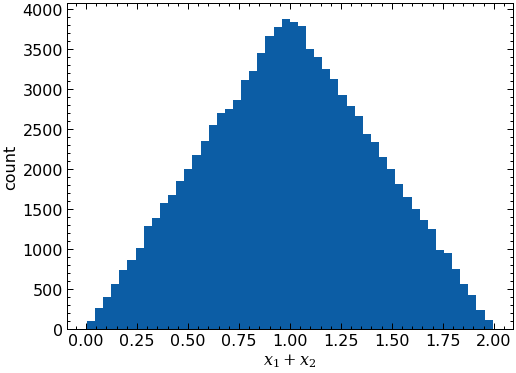

In [32]:
#  两个满足均匀分布的数的和满足三角分布
x1 = np.random.rand(100000)
x2 = np.random.rand(100000)

xsum = x1 + x2
_ = plt.hist(xsum, bins=50)
plt.xlabel(r"$x_1 + x_2$")
plt.ylabel("count")

Text(0, 0.5, 'count')

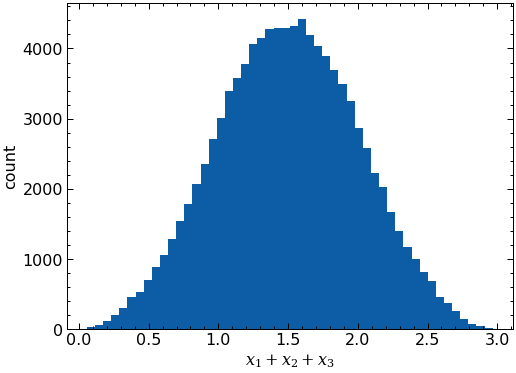

In [33]:
#  3 个数的和
x = np.random.rand(100000, 3)

xsum = x.sum(axis=1)
_ = plt.hist(xsum, bins=50)

plt.xlabel(r"$x_1 + x_2 + x_3$")
plt.ylabel("count")

Text(0, 0.5, 'count')

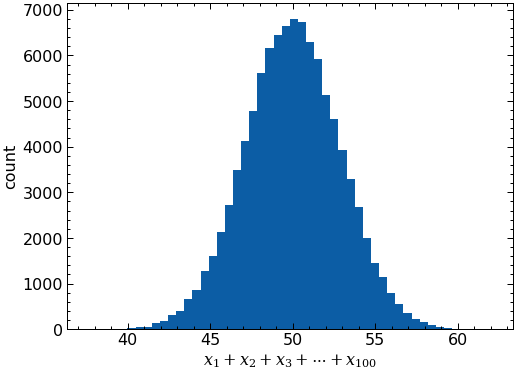

In [35]:
#  100 个满足均匀分布的数的和
x = np.random.rand(100000, 100)

xsum = x.sum(axis=1)

_ = plt.hist(xsum, bins=50)

plt.xlabel(r"$x_1 + x_2 + x_3 + \cdots +x_{100}$")
plt.ylabel("count")

依据中心极限定理，蒙卡积分结果是多个随机变量 $f(x_i)$ 的求和。

\begin{align}
I_n = \int_V f({\bf x}) dV  = \mathcal{V} \ \mathrm{E}\left[ f(x)\right] \approx  \frac{\mathcal{V}}{n}\sum_i^n f({\bf x_i})
\end{align}


假设 n 有限，多次蒙卡积分得到的 $\{ I_n \}$ 满足正态分布。

设积分的误差为 $\epsilon = I_n - I$， 其中 $I$ 是积分的期望值，则 $\epsilon$ 满足 $\mu=0$， 标准差为 ${\sigma(f) \over \sqrt{N}}$ 的正态分布。

蒙特卡洛积分的误差与维度无关，而与 f 在 $\{x_i\}$ 上的标准差 $\sigma[f]$ 和撒点的个数有关，

\begin{align}
Error \propto {\sigma[f] \over \sqrt{N}}
\end{align}

有两种办法可以提高蒙特卡洛积分的精度。

第一种是多撒点，将撒点个数 n  每增加 100 倍，蒙卡积分的误差就会减小为原来的十分之一。这个结论独立于积分的维数。

第二种是减小 $\{ f(x_i \}$ 的涨落（标准偏差 std）。

**问题**：如何减小在抽样点上被积函数 $f(x)$ 的涨落？

注意到当 f(x) 偏离均匀分布较远时，使用均匀分布抽样一系列点 $x_i$ , 则 $\{f(x_i)\}$ 会有较大涨落。

如果 f(x) 在所有点上的函数值接近，趋近于常数，则 $\{f(x_i)\}$ 涨落比较小，求积就很精确。

原因：常数函数的标准差为0。 

证明：如果 $f(x_i)=c$, 其中 $c$ 为常数, 则 $ \sigma\left(f(x_i)\right) = {1 \over n}\sum_i (c - \overline{c})^2 = 0$

下面用程序来验证此结论，

1. 第一种测试： $x_i$ 服从 [0, 1] 区间均匀分布， 计算 $f(x)=1$ 在 $x_i$ 上的函数值集合 $\{ f(x_i) \}$ 的标准差 fxi.std()

In [7]:
# 第一种测试： xi 均匀分布， f(x) = 1
n = 10000
xi = np.random.rand(n)
fxi = np.ones_like(xi)

fxi.std()

0.0

2. 第二种测试：$x_i$ 服从 [-1, 1] 区间均匀分布， 计算标准正态分布 $f(x)= 1/\sqrt{2\pi} \exp(-x^2/2)$ 在 $\{ f(x_i) \}$ 的标准差 fxi.std()


In [20]:
# 第二种测试： xi 均匀分布， f(x) 是标准正态分布

n = 10000

xi = 2 * np.random.rand(n) - 1

fxi = 1/np.sqrt(2*np.pi) * np.exp(-0.5*xi*xi)

fxi.std()

0.04844730012863755

3. 第三种测试： $x_i$ 服从标准正态分布，计算均匀分布的概率密度函数 $f(x)=1$ 在 $\{ f(x_i) \}$ 的标准差 fxi.std()

In [17]:
# 第三种测试： xi 服从标准正态分布， f(x)=1

n = 10000

xi = np.random.randn(n)

fxi = np.ones_like(xi)

fxi.std()

0.0

**答案**：选择一个与 f(x) 形式相近，但比较好抽样的函数 g(x), 将积分写为， 

\begin{align}
F = \int_\mathcal{V}  \frac{f(x)}{g(x)} g(x)  dx = \mathcal{V} \ \mathbb{E}_g \left[ \frac{f(x)}{g(x)}  \right]
\end{align}

其中 $\mathbb{E}_g(\cdot)$ 表示按照 $dG(x) = g(x) dx$ 抽样，在得到的点上计算均值 $\frac{1}{N} \sum_i^N \frac{f(x_i)}{g(x_i)} $。

如果 $g(x)$ 与 $f(x)$ 函数形式相近， $f(x)/g(x)$ 接近常数，则 $\sigma(f/g)$ 很小，蒙卡积分误差变小。

这种方法称作**重要抽样积分**。

这种重要抽样方法可以大大加快蒙特卡洛积分的收敛速度。

但与暴力增加 n 相比， g(x)  函数的具体形式依赖于被积函数。

与 Vegas 程序类似的高维蒙卡积分都使用适配(Adaptive)的方式，自动寻找 g(x)。

VEGAS 积分有两个版本。经典版本 VEGAS 与进化版本 VEGAS+。下面是 VEGAS+ 文章的摘要，第 2 句话说明经典 vegas 使用了适配重要抽样，而 vegas+ 额外添加了适配分层抽样。

    We describe a new algorithm, VEGAS+, for adaptive multidimensional Monte Carlo integration. The new algorithm adds a second adaptive strategy, adaptive stratified sampling, to the adaptive importance sampling that is the basis for its widely used predecessor VEGAS. Both VEGAS and VEGAS+ are effective for integrands with large peaks, but VEGAS+ can be much more effective for integrands with multiple peaks or other significant structures aligned with diagonals of the integration volume. We give examples where VEGAS+ is 2-17 times more accurate than VEGAS. We also show how to combine VEGAS+ with other integrators, such as the widely available MISER algorithm, to make new hybrid integrators. For a different kind of hybrid, we show how to use integrand samples, generated using MCMC or other methods, to optimize VEGAS+ before integrating. We give an example where preconditioned VEGAS+ is more than 100 times as efficient as VEGAS+ without preconditioning. Finally, we give examples where VEGAS+ is more than 10 times as efficient as MCMC for Bayesian integrals with D = 3 and 21 parameters. We explain why VEGAS+ will often outperform MCMC for small and moderate sized problems.

### 原始 VEGAS 积分

原始版本将积分区域分成 N 份，然后动态调整每份的宽度 $\Delta x_i$ ，使得 $f(x_i) \Delta x_i$ 的值趋于常数。即

$f(x_0) \Delta x_0 \approx f(x_1) \Delta x_1 \approx ... \approx f(x_n) \Delta(x_n) = {\rm const}$

这种方法使 f(x)  值较大的地方，格子分的细，f(x)  值较小的地方，格子分的粗。从而完成重要抽样的目的，减小积分误差。

原始 VEGAS 积分对于峰值平行于自变量方向的函数比较有效。如果被积函数有多个峰值，则会产生很多“假峰”区域, 比如，

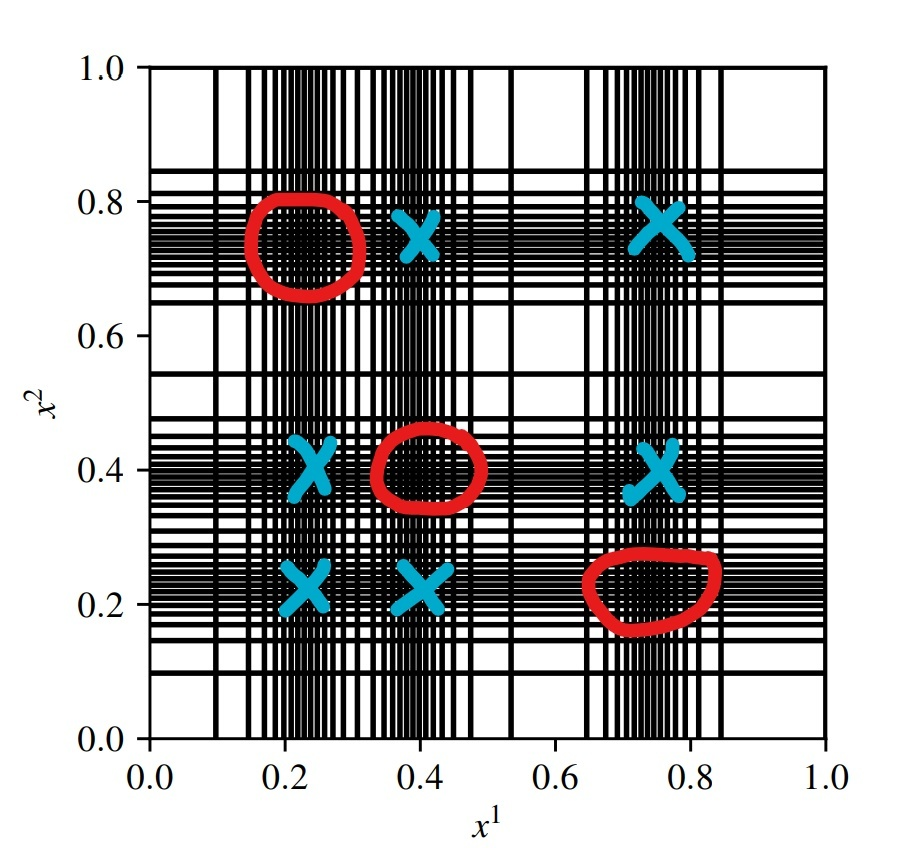

In [5]:
Image("images/vegas_fake_peaks.jpg", width=600, height=400)

比如二维积分，有3个峰值，区域在红色圆圈附近，根据原始 VEGAS 积分的自适应方法，会额外产生6个“假峰”，用蓝色 x 标记，被积函数 $f(x_1, x_2)$ 在这些区域的值接近于 0，而自适应方法会在这 6 个区域产生很多积分点，导致 原始 VEGAS 积分效率低下。

在高维积分中，如果被积函数有多个对角峰值，情况会更加严重。比如 10 维下的 3 对角峰值，这样的“假峰”会有 $3^{10} - 3$ 个。

### 进化版 vegas 积分

进化版 VEGAS+ 额外加入自适应分层抽样 Adaptive Stratified Integration。

将积分区域分成很多小的超立方 cube，如果某个 cube 中的积分值多次迭代方差较大，就将区域细分。做多个峰值的积分更高效，比原始版本精度提高 2 到 17 倍。这种方法别的很多地方用到，比如 MISER，FOAM，ZMCIntegral 等。

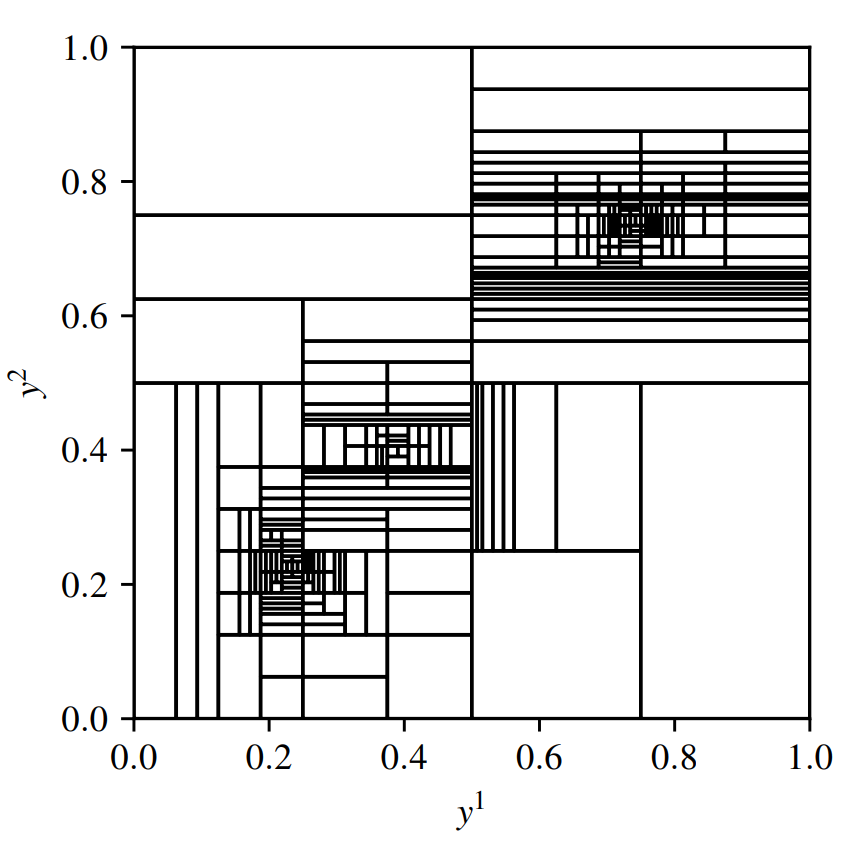

In [6]:
Image("images/vegas_stratified.png", width=600, height=400)

自适应重要抽样加分层抽样法加成的 VEGAS+ 在多个高维积分任务上都表现不错。
另外，2009年的文章还提到一种新方法，使用马尔科夫链蒙特卡洛 MCMC 先寻找被积函数的峰值位置，预产生一些积分位置，然后送入 VEGAS+ 中，可以比从零开始的 VEGAS+ 加速100倍。

最近有人用神经网络生成模型中的流模型（flow model） 编写了一个类似于 VEGAS 的高维数值积分程序，i-flow。因为流模型双射，可逆，雅可比矩阵好算等特征，使得它非常适合高维数值积分。如果实际工作中发现 Vegas 表现不尽人意，可以尝试 i-flow。

**参考文献**

【1】源代码：https://github.com/gplepage/vegas

【2】文档：https://vegas.readthedocs.io/

【3】文章：https://arxiv.org/abs/2009.05112

【4】vegas原始文献：G. P. Lepage, J. Comput. Phys. 27(1978) 192.

## 附录：


蒙特卡洛积分的形式
\begin{align}
\int_a^b f(x) dx & = (b - a) E[f(x)] 
\end{align}

非常像**积分中值定理**：若函数 $f(x)$ 在闭区间 [a, b] 上连续，则在积分区间上必存在一点 $\epsilon$, 使得，

\begin{align}
\int_a^b f(x) dx = (b-a) f(\epsilon)
\end{align}

**蒙特卡洛积分均值与误差的证明**

下面计算一下蒙特卡洛积分 $I_n =  \frac{\mathcal{V}}{n}\sum_i^n f({\bf x_i})$ 满足的正态分布的均值和标准差，

设 $\zeta$ 是 [a, b] 区间上满足均匀分布的随机变量，其分布函数为，

\begin{align}
P(x &< \zeta \le x + dx) = g(x) dx 
\end{align}

其中 $ g(x)$ 是均匀分布的概率密度分布函数。


\begin{align}
g(x) &= \left\{ \begin{array}{ll}
{1 \over b - a}  & \mbox{for}\ x \in [a, b] \\
0 & \mbox{else} 
\end{array}\right.
\end{align}

则被积函数 $f(x)$ 的期望值为，

\begin{align}
E[f(x)] = \int_{-\infty}^{\infty} f(x) g(x)dx = {1 \over b-a} \int_a^b f(x) dx \approx {1 \over N} \sum_{i=1}^N f(\zeta_i)
\end{align}

为了估计误差，我们定义新的随机变量，$\gamma = {1 \over N} \sum_{i=1}^N f(\zeta_i)$, 则得到 $\gamma$ 的期望值，

\begin{align}
\overline{\gamma} = E[\gamma] = {1 \over N} \sum_{i=1}^N E[f(x)] = E[f(x)]
\end{align}

$\gamma$ 的方差为，

\begin{align}
\sigma_{\gamma}^2 &= E[(\gamma - \bar{\gamma})^2] \\
& = E\left[\left({1 \over N} \sum f(\zeta_i) - \overline{\gamma}\right)^2 \right] \\
& = E\left[\left({1 \over N} \sum \left( f(\zeta_i) - \overline{\gamma}\right)\right)^2 \right] \\
& = {1 \over N^2} E\left[ \sum \left( f(\zeta_i) - \overline{\gamma}\right)^2 \right] \\
& = {1 \over N} \left( \overline{f(\zeta)^2}-  \overline{f(\zeta)}^2 \right) = {\sigma_{f(\zeta)}^2 \over N}
\end{align}